In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import halotools

In [3]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools.utils import group_member_generator
from halotools.utils import randomly_downsample_data
from halotools.mock_observables import mean_y_vs_x
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import tpcf
from halotools.mock_observables import tpcf_one_two_halo_decomp
from halotools.mock_observables import delta_sigma

In [4]:
model = PrebuiltSubhaloModelFactory('smhm_binary_sfr')
# dir(model)
# populate model catalog

In [5]:
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift = 0, halo_finder = 'rockstar')
model.populate_mock(halocat)

# populate simulation/ monte carlo realization
# monte carlo statistics w/ uncertainties 

## galaxy properties as a function of halo mass

In [6]:
sample_mask = model.mock.galaxy_table['stellar_mass'] > 1e10
gals = model.mock.galaxy_table[sample_mask]

# cut data for M > 10^10 M

In [7]:
# group member generator, group calculations 

gals.sort('halo_hostid') 
# grouping key for galaxy catalogs w/ known hosts 
# sort galaxies in column 

grouping_key='halo_hostid'

requested_columns=['stellar_mass']
# yeild data stored in column 

group_gen=group_member_generator(gals, grouping_key, requested_columns)


In [8]:
# loop to generate sum of stellar mass 
# broadcast result to each group member

total_stellar_mass=np.zeros(len(gals))
for first, last, member_props in group_gen:
    stellar_mass_of_members=member_props[0]
    total_stellar_mass[first:last]=sum(stellar_mass_of_members)
    
gals['halo_total_stellar_mass']=total_stellar_mass

#gals table has halo stellar mass column

In [9]:
gals.sort(['halo_hostid', 'halo_upid'])
grouping_key = 'halo_hostid' 
# common halos are grouped -> central gal appears first

requested_columns = ['halo_mvir']
group_gen = group_member_generator(gals, grouping_key, requested_columns)

In [10]:
host_mass = np.zeros(len(gals))
for first, last, member_props in group_gen:
    mvir_members = member_props[0]
    mvir_host = mvir_members[0]
    host_mass[first:last] = mvir_host

gals['halo_mhost'] = host_mass #new column 

In [11]:
bins = np.logspace(12, 15, 25)
result = mean_y_vs_x(gals['halo_mhost'].data,
                     gals['halo_total_stellar_mass'].data,
                     bins = bins,
                     error_estimator = 'variance')

host_mass, mean_stellar_mass, mean_stellar_mass_err = result

(10712418768.491386, 5000000000000.0)

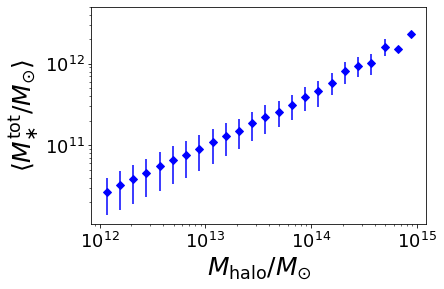

In [12]:
plt.errorbar(host_mass, mean_stellar_mass, yerr=mean_stellar_mass_err,
             fmt = "none", ecolor='blue')
plt.plot(host_mass, mean_stellar_mass, 'D', color='b')

plt.loglog()
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r'$M_{\rm halo}/M_{\odot}$', fontsize=25)
plt.ylabel(r'$\langle M_{\ast}^{\rm tot}/M_{\odot}\rangle$', fontsize=25)
plt.ylim(ymax=5e12)

# average stellar mass vs halo mass

In [13]:
# calculate average trends as a function of halo mass
# as a funtion of = halo mass = x

cens_mask = gals['halo_upid'] == -1
cens = gals[cens_mask]
sats = gals[~cens_mask]

bins = np.logspace(12, 14.5, 15)

# centrals
result = mean_y_vs_x(cens['halo_mhost'].data, cens['quiescent'].data,
            bins = bins)
host_mass, fq_cens, fq_cens_err_on_mean = result

# satellites
result = mean_y_vs_x(sats['halo_mhost'].data, sats['quiescent'].data,
            bins = bins)
host_mass, fq_sats, fq_sats_err_on_mean = result

Text(0.5, 1.0, 'Central galaxy quenching: model vs. mock')

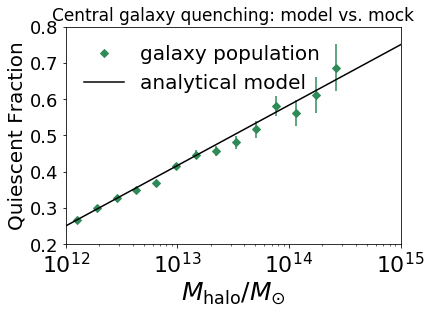

In [14]:
plt.errorbar(host_mass, fq_cens, yerr=fq_cens_err_on_mean,
             color='seagreen', fmt = "none")
plt.plot(host_mass, fq_cens, 'D', color='seagreen',
             label = 'galaxy population')

analytic_result_mhost_bins = np.logspace(10, 15.5, 100)
analytic_result_mean_quiescent_fraction = model.mean_quiescent_fraction(prim_haloprop = analytic_result_mhost_bins)
plt.plot(analytic_result_mhost_bins,
         analytic_result_mean_quiescent_fraction,
         color='black', label = 'analytical model')

plt.xscale('log')
plt.xticks(size=22)
plt.yticks(size=18)
plt.xlabel(r'$M_{\rm halo}/M_{\odot}$', fontsize=25)
plt.ylabel('Quiescent Fraction', fontsize=20)
plt.xlim(xmin = 1e12, xmax = 1e15)
plt.ylim(ymin = 0.2, ymax=0.8)
plt.legend(frameon=False, loc='best', fontsize=20)
plt.title('Central galaxy quenching: model vs. mock', fontsize=17)

## calculating galaxy cluster in 3d

In [15]:
x=model.mock.galaxy_table['x']
y=model.mock.galaxy_table['y']
z=model.mock.galaxy_table['z']

# format arrays

In [16]:
sample_mask=model.mock.galaxy_table['stellar_mass']>1e10
pos=return_xyz_formatted_array(x,y,z, mask=sample_mask)

# only fraction of data

In [17]:
#calculate clustering

rbins=np.logspace(-1,1.25,15)
rbin_centers=(rbins[1:]+rbins[:-1])/2.

xi_all=tpcf(pos, rbins, period=model.mock.Lbox, num_threads='max')

In [18]:
halo_hostid=model.mock.galaxy_table['halo_hostid'][sample_mask]
xi_1h, xi_2h =tpcf_one_two_halo_decomp(pos,
                                      halo_hostid, rbins,
                                      period=model.mock.Lbox,
                                      num_threads='max')

# decomposed contributions from 
# galaxies in same halo
# and galaxies in different halos

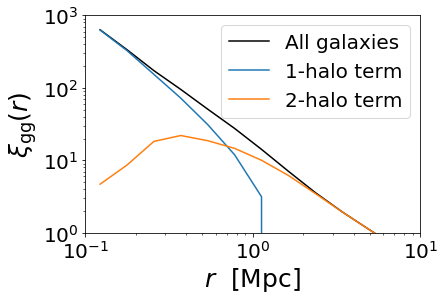

In [19]:
#more matlab lookin'


plt.plot(rbin_centers, xi_all,
         label='All galaxies', color='k')
plt.plot(rbin_centers, xi_1h,
         label= '1-halo term')
plt.plot(rbin_centers, xi_2h,
        label = '2-halo term')

plt.xlim(xmin  = 0.1, xmax = 10)
plt.ylim(ymin = 1, ymax = 1e3)
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r)$', fontsize=25)
plt.legend(loc='best', fontsize=20)

(1, 1000.0)

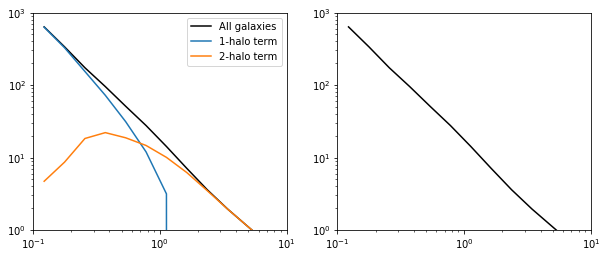

In [20]:
#more pythonic

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax.plot(rbin_centers, xi_all,
        label='All galaxies', color='k')
ax.plot(rbin_centers, xi_1h,
        label= '1-halo term')
ax.plot(rbin_centers, xi_2h,
        label = '2-halo term')

ax.set_xlim(xmin  = 0.1, xmax = 10)
ax.set_ylim(ymin = 1, ymax = 1e3)
ax.loglog()
ax.legend()

ax2.plot(rbin_centers, xi_all, color='k')
ax2.loglog()
ax2.set_xlim(xmin  = 0.1, xmax = 10)
ax2.set_ylim(ymin = 1, ymax=1e3)

## galaxy-galaxy lensing 

#### galaxy-galaxy lensing calculated from cross-correlation b/w gal. positions and DM density field

In [21]:
model=PrebuiltSubhaloModelFactory('behroozi10')
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift = 0, halo_finder = 'rockstar')
model.populate_mock(halocat)

px=model.mock.ptcl_table['x']
py = model.mock.ptcl_table['y']
pz = model.mock.ptcl_table['z']

In [22]:
Nptcls_to_keep=int(1e5)
randomizer=np.random.random(len(model.mock.ptcl_table))
sorted_randoms=np.sort(randomizer)
ptcl_mask=np.where(sorted_randoms<sorted_randoms[Nptcls_to_keep])[0]
particle_positions=return_xyz_formatted_array(px, py, pz, mask=ptcl_mask)

In [23]:
x=model.mock.galaxy_table['x']
y=model.mock.galaxy_table['y']
z=model.mock.galaxy_table['z']

In [24]:
mstar11_mask=model.mock.galaxy_table['stellar_mass']>1e11
mstar11_positions=return_xyz_formatted_array(x,y,z, mask=mstar11_mask)

mstar105_mask=(model.mock.galaxy_table['stellar_mass']>10**10.3)&(model.mock.galaxy_table['stellar_mass']<10**10.7)
mstar105_positions=return_xyz_formatted_array(x,y,z,mask=mstar105_mask)

mstar105_central_mask=mstar105_mask*(model.mock.galaxy_table['halo_upid'] == -1)
mstar105_central_positions = return_xyz_formatted_array(x, y, z, mask = mstar105_central_mask)

mstar105_satellite_mask=mstar105_mask*(model.mock.galaxy_table['halo_upid'] != -1)
mstar105_satellite_positions=return_xyz_formatted_array(x,y,z, mask=mstar105_satellite_mask)

In [25]:
rp_bins=np.logspace(-1, 1, 15)

particle_masses=halocat.particle_mass
period=model.mock.Lbox

In [26]:
downsampling_factor=(halocat.num_ptcl_per_dim**3)/float(len(particle_positions))

AttributeError: 'CachedHaloCatalog' object has no attribute 'num_ptcl_per_dim'